# Import Libraries

In [1]:
import numpy as np
import pandas as pd
from nltk.tokenize import word_tokenize

from nltk.corpus import stopwords

import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer

import random
random.seed(0)
# ignore error
import warnings
warnings.filterwarnings("ignore")

# Premade Functions

In [2]:
def class_distribution_analysis(df):
    """Analyze the distribution of classes"""
    plt.figure(figsize=(12, 6))
    
    # Plot class distribution
    class_dist = df['label'].value_counts()
    sns.barplot(x=class_dist.index, y=class_dist.values)
    plt.title('Class Distribution')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    # Calculate class balance metrics
    total_samples = len(df)
    class_percentages = (class_dist / total_samples * 100).round(2)
    
    print("\nClass Distribution Statistics:")
    print("-" * 50)
    print(f"Total number of samples: {total_samples}")
    print("\nClass-wise breakdown:")
    for class_name, percentage in class_percentages.items():
        print(f"{class_name}: {class_dist[class_name]} samples ({percentage}%)")
    
    # Calculate imbalance metrics
    imbalance_ratio = class_dist.max() / class_dist.min()
    print(f"\nImbalance ratio (majority:minority): {imbalance_ratio:.2f}")
    
    return class_dist

def text_length_analysis(df):
    """Analyze text length distribution by class"""
    # Calculate text lengths
    df['text_length'] = df['text'].str.len()
    df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))
    
    # Create subplots
    fig, axes = plt.subplots(2, 1, figsize=(12, 12))
    
    # Character length distribution by class
    sns.boxplot(data=df, x='label', y='text_length', ax=axes[0])
    axes[0].set_title('Text Length Distribution by Class (Characters)')
    axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
    
    # Word count distribution by class
    sns.boxplot(data=df, x='label', y='word_count', ax=axes[1])
    axes[1].set_title('Word Count Distribution by Class')
    axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()
    
    # Print statistical summary
    print("\nText Length Statistics by Class:")
    print("-" * 50)
    length_stats = df.groupby('label').agg({
        'text_length': ['mean', 'std', 'min', 'max'],
        'word_count': ['mean', 'std', 'min', 'max']
    }).round(2)    
    return length_stats

def vocabulary_analysis(df, top_n=20):
    """Analyze vocabulary characteristics and top terms by class"""
    stop_words = set(stopwords.words('english'))
    
    def get_vocab_stats(text):
        words = word_tokenize(str(text).lower())
        words = [w for w in words if w.isalnum() and w not in stop_words]
        return len(set(words)), len(words), len(set(words))/len(words) if len(words) > 0 else 0
    
    # Calculate vocabulary statistics
    df[['unique_words', 'total_words', 'lexical_diversity']] = pd.DataFrame(
        df['text'].apply(get_vocab_stats).tolist(), index=df.index)
    
    # Plot lexical diversity by class
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df, x='label', y='lexical_diversity')
    plt.title('Lexical Diversity by Class')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    # Get top terms by class
    vectorizer = CountVectorizer(stop_words='english', max_features=1000)
    term_freq = vectorizer.fit_transform(df['text'])
    terms = vectorizer.get_feature_names_out()
    
    # Plot top terms for each class
    unique_classes = df['label'].unique()
    n_classes = len(unique_classes)
    fig, axes = plt.subplots(n_classes, 1, figsize=(12, 6*n_classes))
    if n_classes == 1:
        axes = [axes]
    
    for i, class_label in enumerate(unique_classes):
        class_docs = term_freq[df['label'] == class_label]
        class_term_freq = np.asarray(class_docs.sum(axis=0)).ravel()
        top_term_indices = class_term_freq.argsort()[-top_n:][::-1]
        
        sns.barplot(
            x=[terms[i] for i in top_term_indices],
            y=class_term_freq[top_term_indices],
            ax=axes[i]
        )
        axes[i].set_title(f'Top {top_n} Terms for Class: {class_label}')
        axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()
    
    # Print vocabulary statistics
    print("\nVocabulary Statistics by Class:")
    print("-" * 50)
    vocab_stats = df.groupby('label').agg({
        'unique_words': ['mean', 'std'],
        'total_words': ['mean', 'std'],
        'lexical_diversity': ['mean', 'std']
    }).round(3)    
    return vocab_stats

def print_dataset_info(df):
    """Print basic dataset information and samples"""
    print("Dataset Information:")
    print("-" * 50)
    print(f"Total samples: {len(df)}")
    print(f"Number of classes: {df['label'].nunique()}")
    print("\nClass labels:", ', '.join(df['label'].unique()))
    
    print("\nSample texts from each class:")
    print("-" * 50)
    for label in df['label'].unique():
        sample = df[df['label'] == label].sample(1).iloc[0]
        print(f"\nClass: {label}")
        print("Text:", sample['text'][:200] + "..." if len(sample['text']) > 200 else sample['text'])
        print("-" * 50)

def run_classification_eda(df):
    """Run all analyses for text classification task"""
    print("\nDataset Overview:")
    print("=" * 50)
    print_dataset_info(df)
    
    print("\nClass Distribution Analysis:")
    print("=" * 50)
    class_stats = class_distribution_analysis(df)
    
    print("\nText Length Analysis:")
    print("=" * 50)
    length_stats = text_length_analysis(df)
    
    print("\nVocabulary Analysis:")
    print("=" * 50)
    vocab_stats = vocabulary_analysis(df)
    
    return class_stats, length_stats, vocab_stats

# Read Data

In [3]:
data = pd.read_csv('./data_1C.csv')
data.head()

,Unnamed: 0,text,label
0,0,"Aurion C3 Iron Curl Bar with 2 Locks, 3 ft (Si...",Household
1,1,"Presto 06620 11-Inch Electric Skillet Fries, g...",Household
2,2,WHOOSH! Award-Wining Screen Cleaner - Safe for...,Electronics
3,3,ManQ Men's Blended Waist Coat,Clothing & Accessories
4,4,Lace And Me Women's Blended High Waist Tummy &...,Clothing & Accessories


# PreClean Data
- Remove useless columsn (`Unnamed: 0`)

In [4]:
data = data.drop(['Unnamed: 0'], axis=1)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12606 entries, 0 to 12605
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    12606 non-null  object
 1   label   12606 non-null  object
dtypes: object(2)
memory usage: 197.1+ KB


# EDA (Before Preprocessing)

In [6]:
tempData = data.copy()

In [7]:
tempData.sample(5)

,text,label
1786,Dell MS116 1000DPI USB Wired Optical Mouse Pro...,Electronics
10263,Grandma Gatewood's Walk: The Inspiring Story o...,Books
4974,Broadstar Women Denim Ice Blue Jeans Take A Mo...,Clothing & Accessories
5876,Introduction to Psychology About the Author A ...,Books
8504,Aart Store 4X6 Feet 2 Seater Printed Mechanism...,Household


## WordCloud

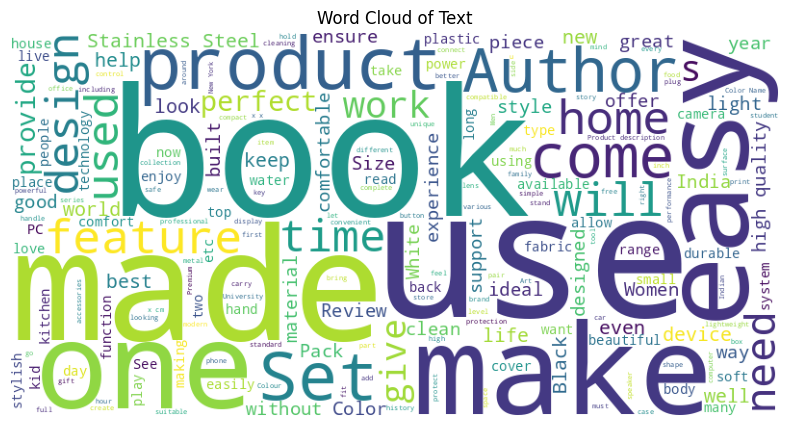

In [8]:
def plot_wordcloud(text, title="Word Cloud"):
    wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(" ".join(text))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(title)
    plt.show()
    
plot_wordcloud(tempData['text'], "Word Cloud of Text")

## Dataset General Info

In [9]:
print_dataset_info(tempData)

Dataset Information:
--------------------------------------------------
Total samples: 12606
Number of classes: 4

Class labels: Household, Electronics, Clothing & Accessories, Books

Sample texts from each class:
--------------------------------------------------

Class: Household
Text: Technuv 12V Car Vacuum Cleaner Handheld Mini Super Suction Wet and Dry Dual Use Vaccum Cleaner for Car 12V Car Handheld Vacuum Cleaner Color：Blue and white Weight：500g Rated Voltage : DC12V Rated inpu...
--------------------------------------------------

Class: Electronics
Text: Canon Pixma G2012 All-in-One Ink Tank Colour Printer (Black) Canon PIXMA G2012 NEW! Refillable Ink Tank All-In-One for High Volume Printing, Designed for high volume printing at low running cost - Pri...
--------------------------------------------------

Class: Clothing & Accessories
Text: Fressia Fabrics Women's Stretchable Readymade Saree Blouse Crop Top Choli Pack of 3 Fressia Fabrics Readymade Saree Blouse Is Made Of Prem

## Check for Missing Values

In [10]:
# missing value check
tempData.isnull().sum()

text     0
label    0
dtype: int64

Based on the sample shown above, we can see that the data is still very dirty and need some preprocessing. 
We will do the following:
- Remove all the special characters
- lower case all the text
- Remove all the stopwords
- Remove all non english words


# Preprocessing

In [11]:
preprocessed_data = data.copy()

## Remove Special Characters

In [12]:
# Remove Special characters
preprocessed_data['text'] = preprocessed_data['text'].str.replace(r"[^a-zA-Z0-9]", " ")
preprocessed_data.sample(5)

,text,label
8092,AMZ Exclusive Premium Quality Soft Rocking Cha...,Household
6492,fanideaz Men's Jacket Give unique collection t...,Clothing & Accessories
2930,"Dynore Stainless Steel Ice Cream Scoop, Silver...",Household
10649,Gulliver's Travels Gulliver's Travels,Books
6221,Godrej Telescopic Channel 500 mm (20 Inches) S...,Household


## Lower Case

In [13]:
preprocessed_data['text'] = preprocessed_data['text'].str.lower()
preprocessed_data.sample(5)

,text,label
1315,klaxon towel ring - bathroom towel holder - st...,Household
6210,kent grand plus 8-litre mineral ro + uv/uf wit...,Household
8531,logitech z625 powerful thx pc speaker (black) ...,Electronics
11085,"the autobiography of martin luther king, jr. a...",Books
11327,ajanta royal individual synthetic polymer wood...,Household


## Remove Stopwords

In [14]:
# remove stopwords
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

preprocessed_data['text'] = preprocessed_data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
preprocessed_data.sample(5)

,text,label
7312,amazon brand - solimo non-stick grill sandwich...,Household
696,word power made easy review helpul gre aptitud...,Books
7368,huawei e8372 unlocked 4g/lte wi-fi wingle (whi...,Electronics
4325,"bbc 066bb gaming cabinet one 33 led fan , 3.0 ...",Household
2085,sona women's perfecto full coverage non-padded...,Clothing & Accessories


## Remove Non-English Words

In [15]:
# remove non-english words
from nltk.corpus import words

english_words = set(words.words())

preprocessed_data['text'] = preprocessed_data['text'].apply(lambda x: ' '.join([word for word in x.split() if word in (english_words)]))
preprocessed_data.sample(5)

,text,label
57,khadi cotton cotton men rich look durable hank...,Clothing & Accessories
11918,international silicone cooking food steel mate...,Household
9364,pedigree puppy dry dog chicken milk pack pedig...,Electronics
11185,book five,Books
4443,cooler master lite tempered glass side panel e...,Electronics


## Check 0 Length Texts

In [16]:
# check for empty text
preprocessed_data[preprocessed_data['text'].str.strip().astype(bool)].info()

<class 'pandas.core.frame.DataFrame'>
Index: 12560 entries, 0 to 12605
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    12560 non-null  object
 1   label   12560 non-null  object
dtypes: object(2)
memory usage: 294.4+ KB


# EDA (After Preprocessing)

In [17]:
eda_data = preprocessed_data.copy()

## WordCloud

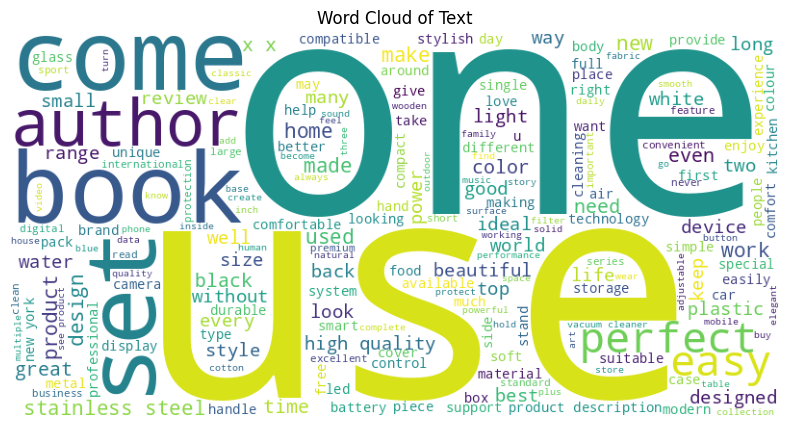

In [18]:
plot_wordcloud(eda_data['text'], "Word Cloud of Text")

## General EDA

### Distribution Analysis

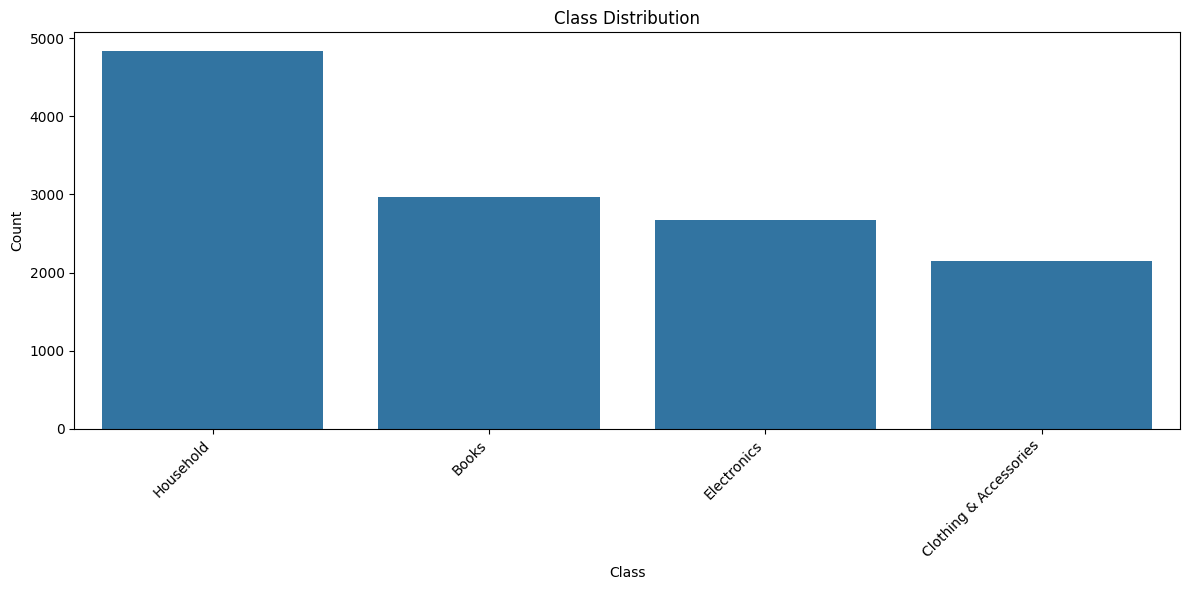


Class Distribution Statistics:
--------------------------------------------------
Total number of samples: 12606

Class-wise breakdown:
Household: 4831 samples (38.32%)
Books: 2961 samples (23.49%)
Electronics: 2670 samples (21.18%)
Clothing & Accessories: 2144 samples (17.01%)

Imbalance ratio (majority:minority): 2.25


label
Household                 4831
Books                     2961
Electronics               2670
Clothing & Accessories    2144
Name: count, dtype: int64

In [19]:
class_distribution_analysis(eda_data)

#### Explanation

Imbalance Ratio: The imbalance ratio is 2.25, which means the most populous class (Household) has 2.25 times more samples than the least populous class (Clothing & Accessories). This level of imbalance can affect model performance, potentially leading to biased predictions.

Visual Representation: The provided image is a bar chart that visually shows the distribution of samples across these classes. From the chart, it's clear that the Household class has the highest count, followed by Books, Electronics, and finally Clothing & Accessories.

#### Insights:

Data Imbalance: The imbalance ratio of 2.25 suggests that data preprocessing steps such as resampling (over-sampling the minority class or under-sampling the majority class) or using algorithms designed to handle imbalanced data might be necessary.

Potential Model Impact: Models trained on this dataset might be biased towards predicting the Household class more accurately due to its higher number of samples. Monitoring and evaluation metrics specific to imbalanced datasets (like precision-recall curves) will be crucial.

### Vocabulary Analysis

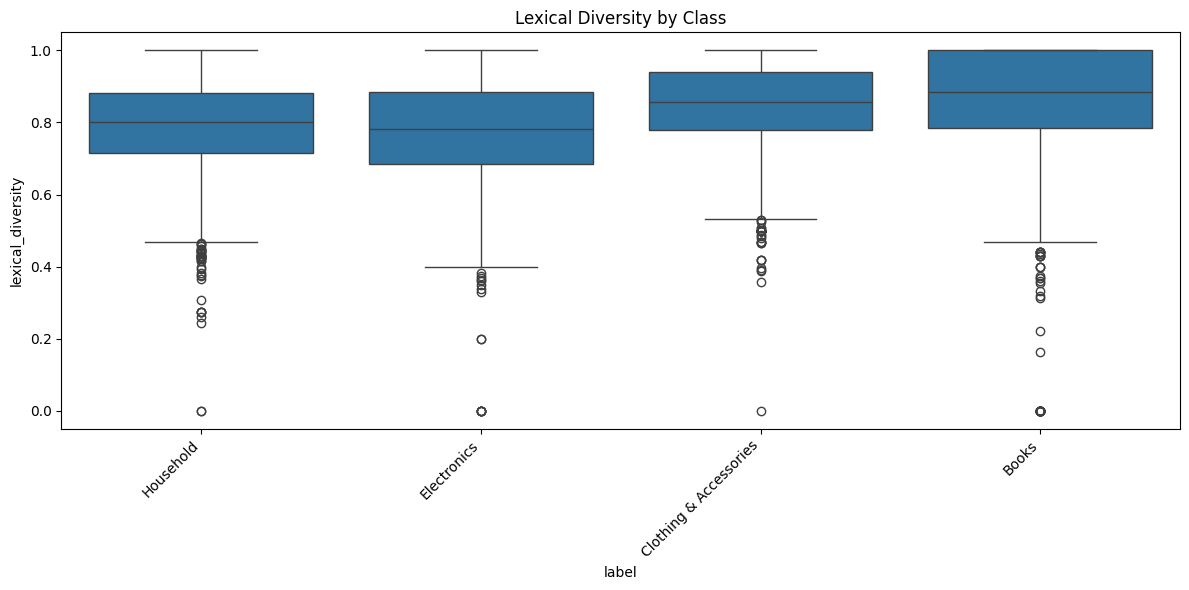

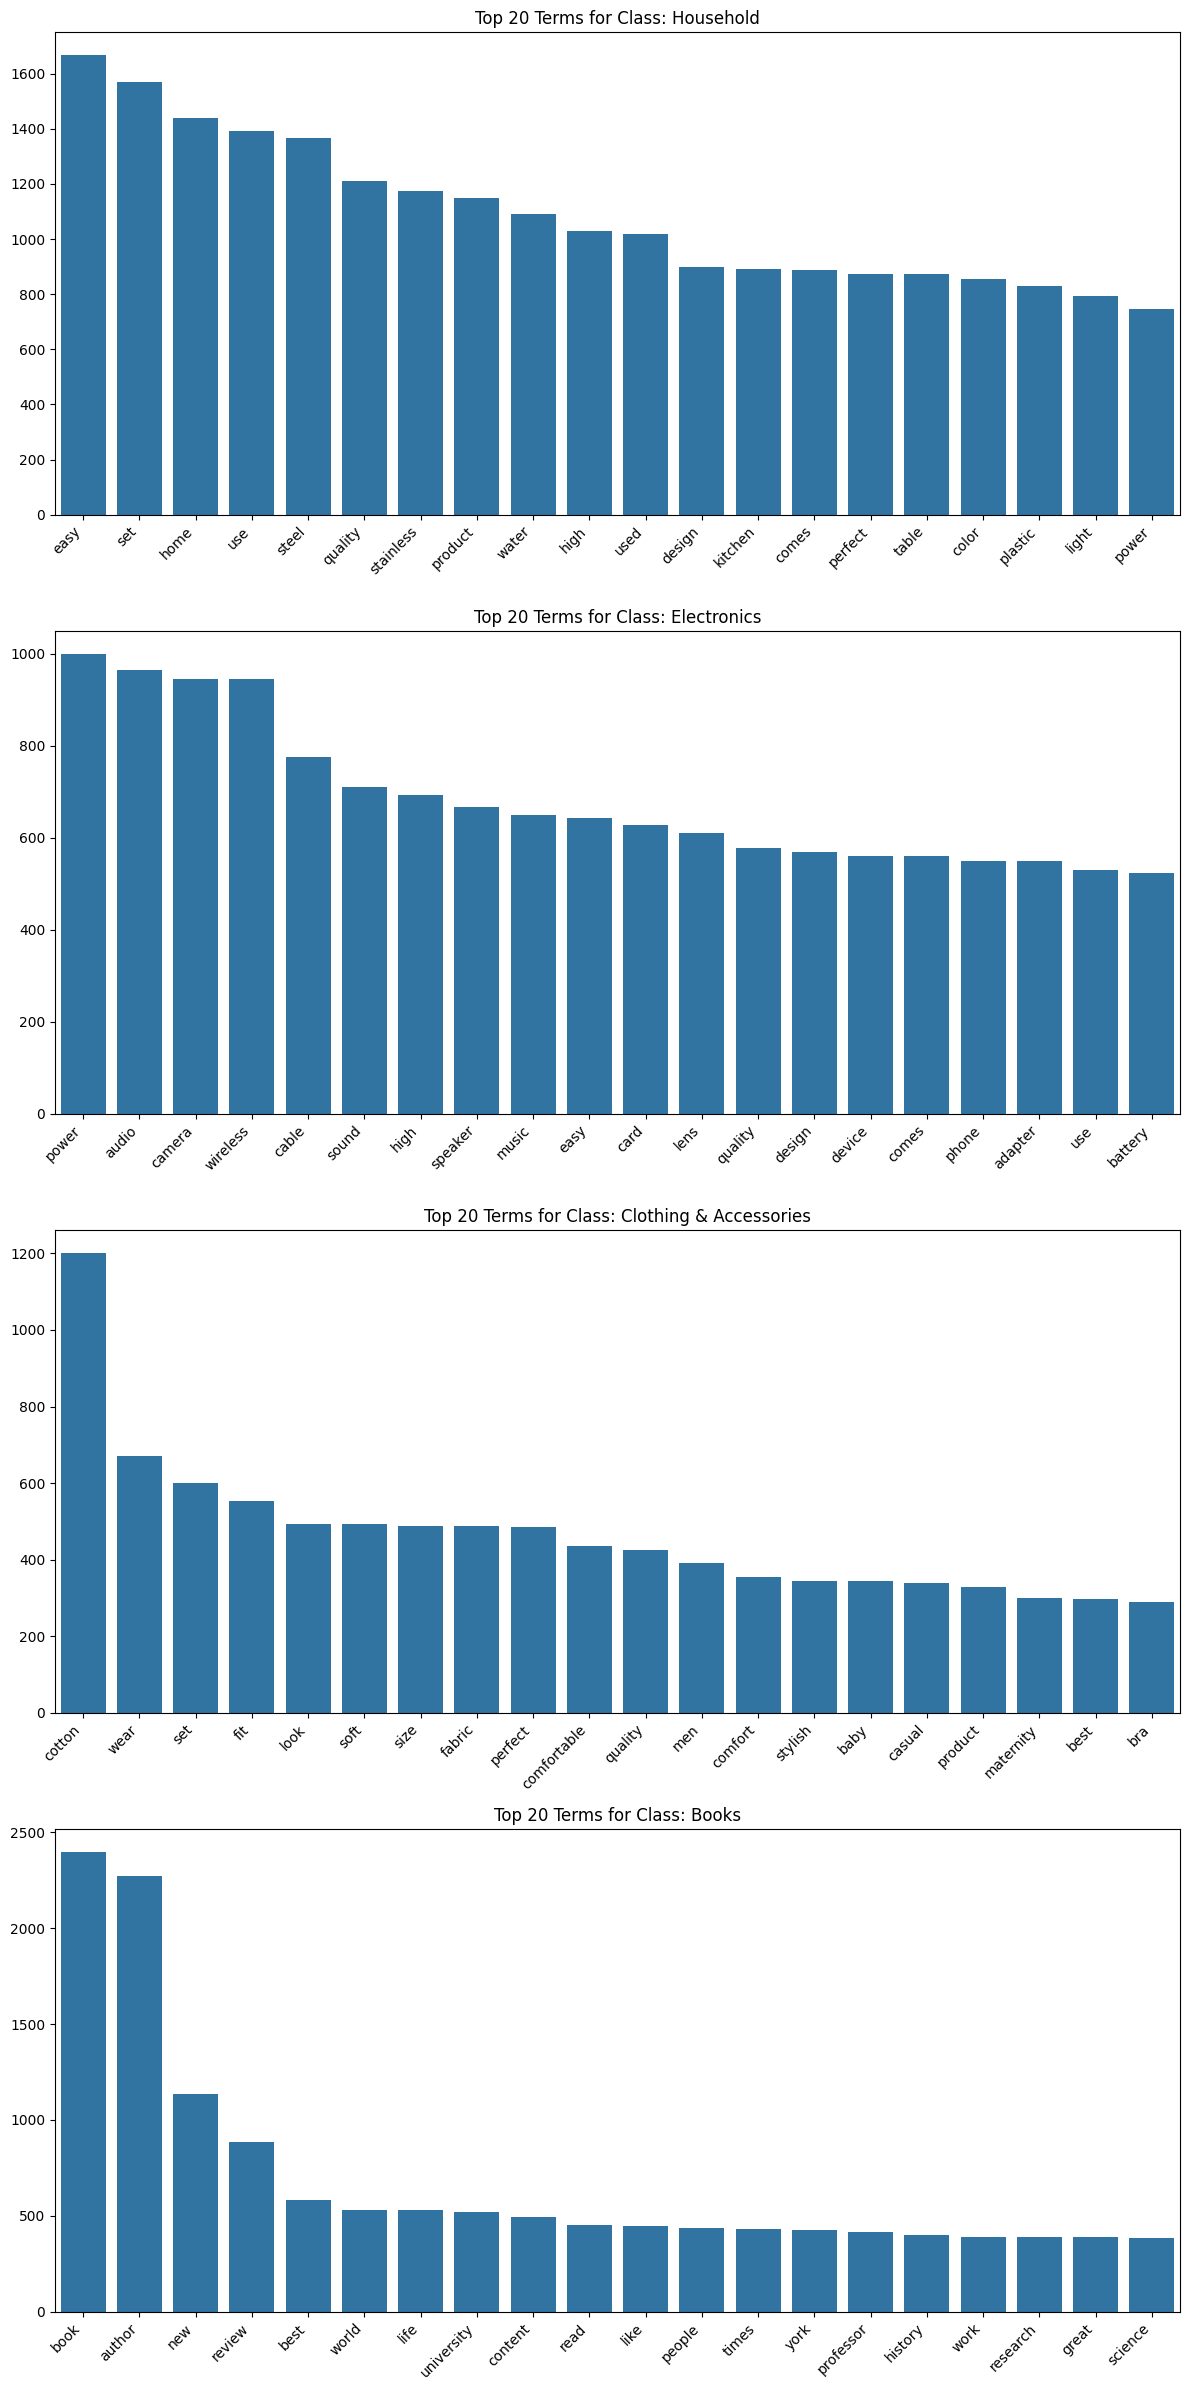


Vocabulary Statistics by Class:
--------------------------------------------------


unique_words         total_words          \
                               mean     std        mean     std   
label                                                             
Books                        34.617  49.805      44.961  80.502   
Clothing & Accessories       24.463  19.462      30.367  26.119   
Electronics                  35.032  29.531      48.536  46.313   
Household                    32.958  25.122      44.631  40.263   

                       lexical_diversity         
                                    mean    std  
label                                            
Books                              0.856  0.163  
Clothing & Accessories             0.849  0.121  
Electronics                        0.780  0.147  
Household                          0.795  0.128

In [20]:
vocabulary_analysis(eda_data)

#### Insights:

##### Lexical Diversity:

Books have the highest lexical diversity (0.856), indicating a wide variety of words used in the text.

Clothing & Accessories follow closely (0.849), suggesting rich vocabulary usage as well.

Electronics and Household have slightly lower diversity, indicating repetitive usage of words compared to Books and Clothing & Accessories.

##### Word Count:

The Electronics class has the highest mean total words (48.536) and unique words (35.032), which might indicate detailed product descriptions.

Books have a high variance in word count, reflected in their standard deviations, showing some reviews or descriptions are much lengthier than others.

##### Variability:

High standard deviations across categories, especially in Books, indicate a significant variation in how verbose the text data can be within each class.

### Text Length Analysis

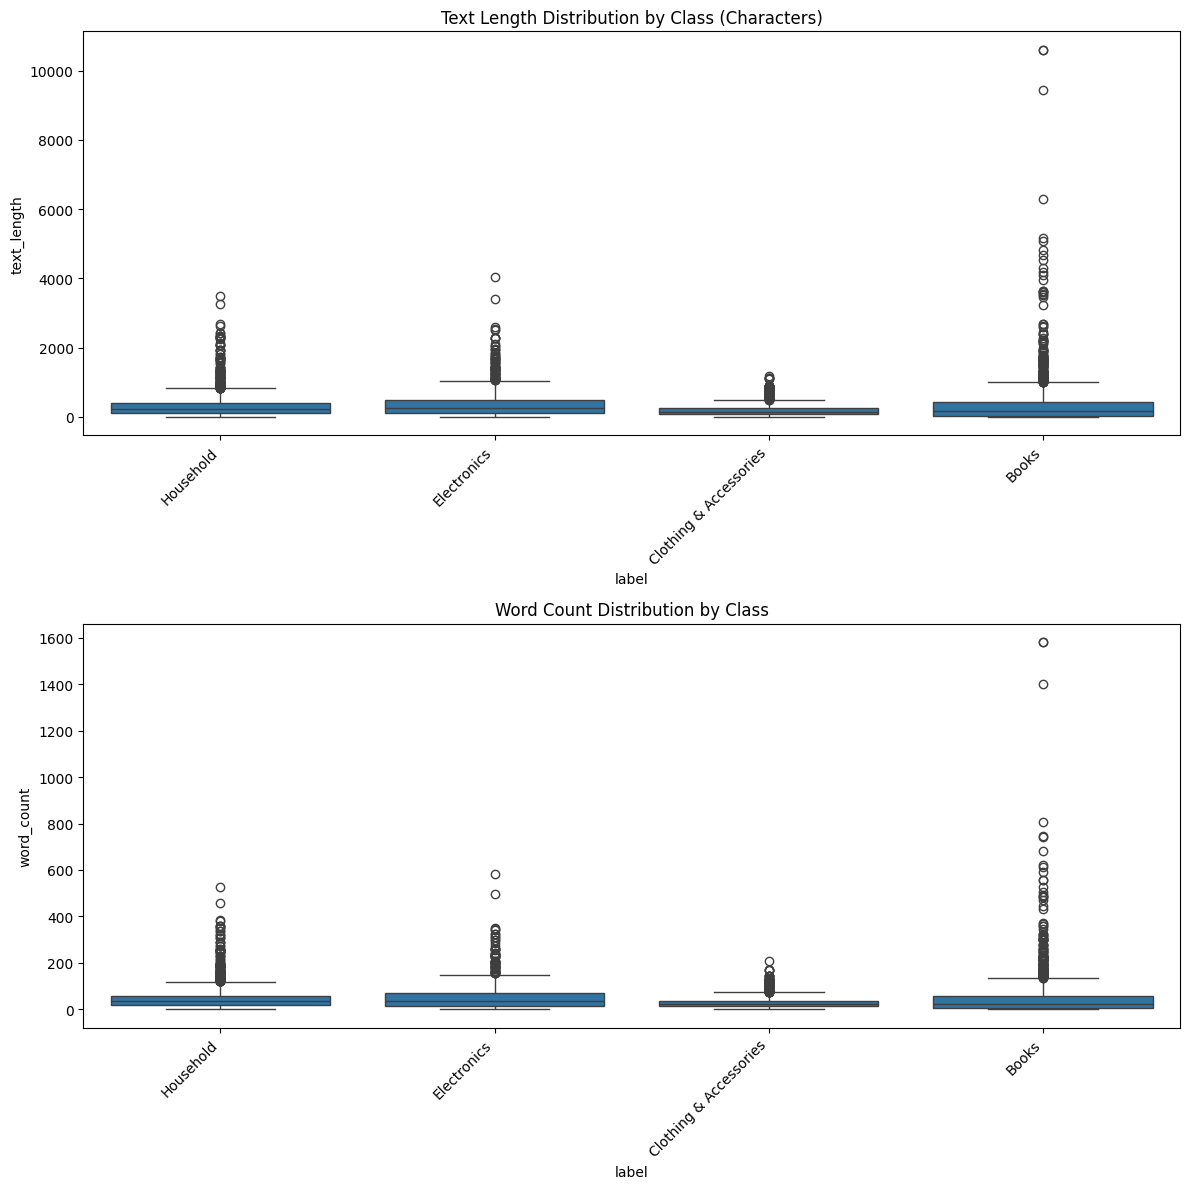


Text Length Statistics by Class:
--------------------------------------------------


text_length                    word_count             \
                              mean     std min    max       mean    std min   
label                                                                         
Books                       331.50  573.89   0  10605      44.97  80.52   0   
Clothing & Accessories      202.13  175.97   0   1181      30.37  26.13   0   
Electronics                 338.76  329.12   0   4047      48.54  46.32   0   
Household                   303.00  277.32   0   3486      44.64  40.27   0   

                              
                         max  
label                         
Books                   1580  
Clothing & Accessories   209  
Electronics              582  
Household                527

In [21]:
text_length_analysis(eda_data)

#### Visual Representation

The box plots comparing the distribution of text length and word count across the four classes. shows, 

Text Length Distribution by Class:

- The Electronics class shows a wide range of text lengths with several outliers.
- Books also exhibit a significant range, with extreme outliers.
- Clothing & Accessories have a more compact range with fewer outliers.

Word Count Distribution by Class:

- Similar trends to text length, with Electronics and Books showing higher variability and range.
- Clothing & Accessories and Household have more compact distributions.

#### Insight

High Variability: There is significant variability in text lengths and word counts, especially in Books, which have the highest standard deviations. This suggests some descriptions are extremely detailed while others are minimal.

Electronics and Books: These classes have the highest mean text lengths and word counts, indicating more detailed content.

Clothing & Accessories: This class has the shortest mean text lengths and word counts, reflecting shorter descriptions.

# Preprocessing for Modeling

- Train-Test Split
- Data Augmentation
- Tokenization

In [22]:
preModelling_data = eda_data.copy()

## Train-Test Split

In [23]:
X = preModelling_data['text']
y = preModelling_data['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
train = pd.concat([X_train, y_train], axis=1)

## Data Augmentation

Awalnya mau back translate, tapi lama buanget so random swap aja

### Back Translation

DON'T RUN THIS CELL (Takes too long)

```python
from googletrans import Translator, LANGUAGES

# Initialize the translator
translator = Translator()

def back_translate(text, src='en', mid='es'):
    """
    Function to perform back translation
    Args:
        text (str): Text to be translated.
        src (str): Source language code.
        mid (str): Intermediate language code for translation.
    
    Returns:
        str: Back translated text.
    """
    try:
        # Translate text to intermediate language
        translated = translator.translate(text, src=src, dest=mid)
        if not translated or not translated.text:
            raise ValueError("Intermediate translation failed.")

        # Translate back to the original language
        back_translated = translator.translate(translated.text, src=mid, dest=src)
        if not back_translated or not back_translated.text:
            raise ValueError("Back translation failed.")
        
        return back_translated.text
    
    except Exception as e:
        print(f"Error during back translation: {e}")
        return text  # Return original text if translation fails

# Example usage
original_text = "This is an example of data augmentation using back translation."
augmented_text = back_translate(original_text)

print("Original Text: ", original_text)
print("Back Translated Text: ", augmented_text)
```

```python
# Apply back translation to the training data to augment under-represented classes
# Define the classes to augment (minority classes) [Books, Clothing & Accessories, Electronics] with target [Household] label count
augment_classes = ['Books', 'Clothing & Accessories', 'Electronics']
target_samples = train['label'].value_counts().max()

# Augment the training data
augmented_samples = []
for class_name in augment_classes:
    # Get samples for the class
    class_samples = train[train['label'] == class_name]['text']
    
    # Calculate number of samples to generate
    n_samples = target_samples - len(class_samples)
    if n_samples <= 0:
        continue
    
    # Perform back translation augmentation
    print(f"Augmenting class '{class_name}' with {n_samples} samples...")
    augmented_samples.extend([
        back_translate(text) for text in class_samples.sample(n=n_samples, replace=True)
    ])
    
# Create augmented data
augmented_data = pd.DataFrame({'text': augmented_samples, 'label': augment_classes[0]})
augmented_data.sample(5)

# Append augmented data to the training set
train_augmented = pd.concat([train, augmented_data], ignore_index=True)

# Check class distribution after augmentation
class_distribution_analysis(train_augmented)
```

### Random Swap

In [25]:
# random swap
def random_swap(sentence, n=2):
    sentence = sentence.split() 
    length = range(len(sentence))
    swapped = []
    for _ in range(n):
        idx1, idx2 = random.sample(length, 2)
        swapped.append([sentence[idx1], sentence[idx2]])
        sentence[idx1], sentence[idx2] = sentence[idx2], sentence[idx1] 
    return ' '.join(sentence)

Augmenting class 'Books' with 1641 samples...
Augmenting class 'Clothing & Accessories' with 2196 samples...
Augmenting class 'Electronics' with 1744 samples...


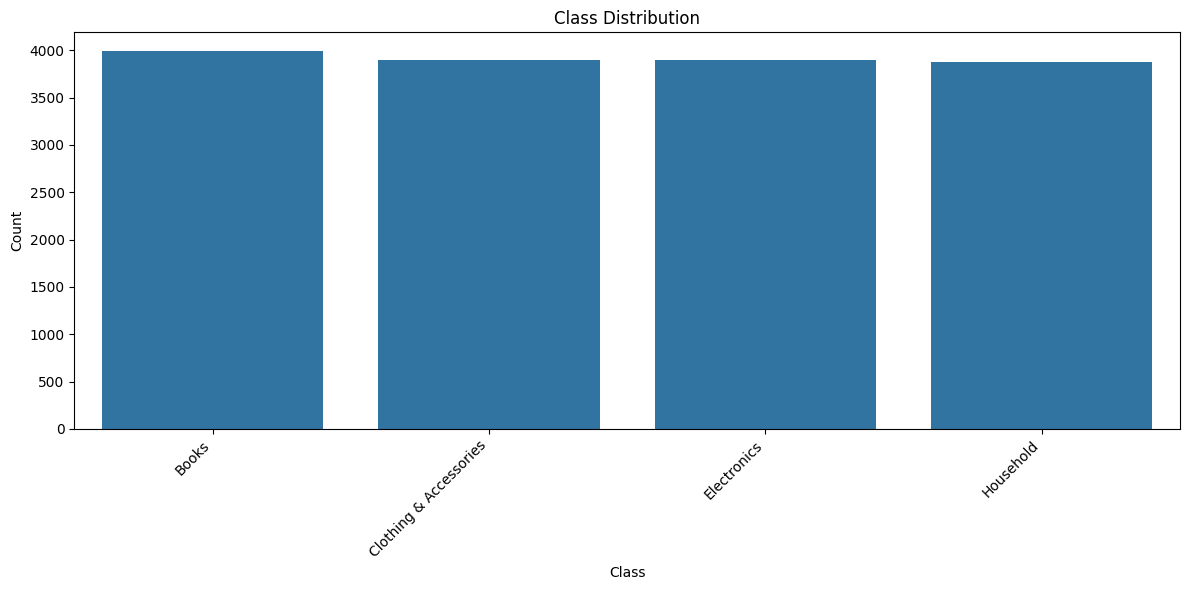


Class Distribution Statistics:
--------------------------------------------------
Total number of samples: 15665

Class-wise breakdown:
Books: 3991 samples (25.48%)
Clothing & Accessories: 3900 samples (24.9%)
Electronics: 3896 samples (24.87%)
Household: 3878 samples (24.76%)

Imbalance ratio (majority:minority): 1.03


label
Books                     3991
Clothing & Accessories    3900
Electronics               3896
Household                 3878
Name: count, dtype: int64

In [26]:
# Apply random swap to the training data to augment under-represented classes
# Define the classes to augment (minority classes) [Books, Clothing & Accessories, Electronics] with target [Household] label count

augment_classes = ['Books', 'Clothing & Accessories', 'Electronics']
target_samples = train['label'].value_counts().max()

augmented_samples = dict(text=[], label = [])
# Augment the training data
for class_name in augment_classes:
    # Get samples for the class
    class_samples = train[train['label'] == class_name]['text']
    
    # check for empty text or 1 word text, if found then remove it
    class_samples = class_samples[class_samples.apply(lambda x: len(x.split()) > 1)]
    
    # Calculate number of samples to generate
    n_samples = target_samples - len(class_samples)
    if n_samples <= 0:
        continue
    
    # Perform random swap augmentation
    print(f"Augmenting class '{class_name}' with {n_samples} samples...")
    augmented_samples['text'].extend([
        random_swap(text) for text in class_samples.sample(n=n_samples, replace=True)
    ])
    augmented_samples['label'].extend([class_name] * n_samples)
    
# Create augmented data
augmented_data = pd.DataFrame(augmented_samples)

# Append augmented data to the training set
train_augmented = pd.concat([train, augmented_data], ignore_index=True)

# Check class distribution after augmentation
class_distribution_analysis(train_augmented)

## Vectorization

In [27]:
X_train_augmented = train_augmented['text']
Y_train_augmented = train_augmented['label']

### Count Vecotorizer

In [28]:
%%timeit

# tokenization using CountVectorizer
countVectorizer = CountVectorizer()
countVectorizer.fit(X_train_augmented)

X_train_CV = countVectorizer.transform(X_train_augmented)
X_test_CV = countVectorizer.transform(X_test)

568 ms ± 24.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [29]:
# tokenization using CountVectorizer
countVectorizer = CountVectorizer()
countVectorizer.fit(X_train_augmented)

X_train_CV = countVectorizer.transform(X_train_augmented)
X_test_CV = countVectorizer.transform(X_test)

### TF-IDF

In [30]:
%%timeit

# Vectorization using TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

TFIDFVec = TfidfVectorizer()
TFIDFVec.fit(X_train_augmented)

X_train_TF = TFIDFVec.transform(X_train_augmented)
X_test_TF = TFIDFVec.transform(X_test)

600 ms ± 18.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [31]:
# Vectorization using TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

TFIDFVec = TfidfVectorizer()
TFIDFVec.fit(X_train_augmented)

X_train_TF = TFIDFVec.transform(X_train_augmented)
X_test_TF = TFIDFVec.transform(X_test)

# Modeling

## Model Selection

### Random Forest

#### Count Vectorizer

##### Time Analysis

In [32]:
%%timeit

rf = RandomForestClassifier(n_estimators=100,  random_state=42, criterion='entropy')

rf.fit(X_train_CV, Y_train_augmented)

# Predict on the test data
y_pred = rf.predict(X_test_CV)

10.8 s ± 134 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


##### Real Training

In [33]:
rf = RandomForestClassifier(n_estimators=100,  random_state=42, criterion='entropy')

rf.fit(X_train_CV, Y_train_augmented)

# Predict on the test data
y_pred = rf.predict(X_test_CV)

print("Classification Report: \n", classification_report(y_test, y_pred))

Classification Report: 
                         precision    recall  f1-score   support

                 Books       0.93      0.94      0.94       611
Clothing & Accessories       0.93      0.94      0.93       440
           Electronics       0.93      0.91      0.92       518
             Household       0.93      0.92      0.93       953

              accuracy                           0.93      2522
             macro avg       0.93      0.93      0.93      2522
          weighted avg       0.93      0.93      0.93      2522



#### TF-IDF

##### Time Analysis

In [35]:
%%timeit

rf = RandomForestClassifier(n_estimators=100, random_state=42, criterion='entropy')

rf.fit(X_train_TF, Y_train_augmented)

# Predict on the test data
y_pred = rf.predict(X_test_TF)

11.6 s ± 1.09 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


##### Real Training

In [36]:
rf = RandomForestClassifier(n_estimators=100, random_state=42, criterion='entropy')

rf.fit(X_train_TF, Y_train_augmented)

# Predict on the test data
y_pred = rf.predict(X_test_TF)

print("Classification Report: \n", classification_report(y_test, y_pred))

Classification Report: 
                         precision    recall  f1-score   support

                 Books       0.93      0.94      0.94       611
Clothing & Accessories       0.94      0.93      0.93       440
           Electronics       0.93      0.90      0.92       518
             Household       0.91      0.93      0.92       953

              accuracy                           0.93      2522
             macro avg       0.93      0.92      0.93      2522
          weighted avg       0.93      0.93      0.93      2522



### Support Vector Machine

#### Count Vectorizer

##### Time Analysis

In [37]:
%%timeit

svc = SVC(kernel='linear', C=1, random_state=42)

svc.fit(X_train_CV, Y_train_augmented)

# Predict on the test data
y_pred = svc.predict(X_test_CV)

11.6 s ± 622 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


##### Real Training

In [38]:
svc = SVC(kernel='linear', C=1, random_state=42)

svc.fit(X_train_CV, Y_train_augmented)

# Predict on the test data
y_pred = svc.predict(X_test_CV)

print("Classification Report: \n", classification_report(y_test, y_pred))

Classification Report: 
                         precision    recall  f1-score   support

                 Books       0.88      0.92      0.90       611
Clothing & Accessories       0.93      0.92      0.92       440
           Electronics       0.92      0.89      0.90       518
             Household       0.93      0.92      0.93       953

              accuracy                           0.91      2522
             macro avg       0.91      0.91      0.91      2522
          weighted avg       0.91      0.91      0.91      2522



#### TF-IDF

##### Time Analysis

In [39]:
%%timeit

svc = SVC(kernel='linear', C=1, random_state=42)

svc.fit(X_train_TF, Y_train_augmented)

# Predict on the test data
y_pred = svc.predict(X_test_TF)

19.1 s ± 415 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


##### Real Training

In [40]:
svc = SVC(kernel='linear', C=1, random_state=42)

svc.fit(X_train_TF, Y_train_augmented)

# Predict on the test data
y_pred = svc.predict(X_test_TF)

print("Classification Report: \n", classification_report(y_test, y_pred))

Classification Report: 
                         precision    recall  f1-score   support

                 Books       0.95      0.94      0.95       611
Clothing & Accessories       0.96      0.95      0.96       440
           Electronics       0.94      0.92      0.93       518
             Household       0.95      0.97      0.96       953

              accuracy                           0.95      2522
             macro avg       0.95      0.95      0.95      2522
          weighted avg       0.95      0.95      0.95      2522

